In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_fetching import hist_data
from data_fetching import get_instrument_key
from charges import charges_delivery
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import math
import os
from dotenv import load_dotenv



In [2]:
path = os.path.abspath("acess_token.env")
load_dotenv(path)
access_token = os.getenv("ACCESS_TOKEN")
if not access_token:
    raise ValueError("ACCESS_TOKEN environment variable is not set.")


In [3]:

    # FMCG / Consumer Staples
FMCG_TICKER = ["DABUR", "MARICO", "GODREJCP", "COLPAL", "BRITANNIA", "NESTLEIND", "TATACONSUM", "UBL", "RADICO"]

# Utilities / Energy
ENERGY_TICKER = ["POWERGRID", "NTPC", "NHPC", "CESC", "TORNTPOWER", "ADANIGREEN", "JSWENERGY", "RECLTD", "PFC", "NHPC"]

# Oil & Gas (PSUs + Pvt)
OIL_GAS_TICKER = ["IOC", "BPCL", "ONGC", "GAIL", "OIL", "PETRONET", "RELIANCE", "GUJGASLTD", "MGL", "IGL"]

# Pharma
PHARMA_TICKER = ["CIPLA", "DRREDDY", "SUNPHARMA", "AUROPHARMA", "DIVISLAB", "LUPIN", "ALKEM", "TORNTPHARM", "ZYDUSLIFE", "BIOCON"]

# Cement & Building Materials
CEMENT_TICKER = ["ULTRACEMCO", "SHREECEM", "AMBUJACEM", "ACC", "DALBHARAT", "JKCEMENT", "INDIACEM"]

# Metals & Mining
METALS_TICKER = ["TATASTEEL", "JSWSTEEL", "HINDALCO", "NMDC", "SAIL", "VEDL", "JINDALSTEL"]

# IT
IT_TICKER = ["INFY", "TCS", "WIPRO", "HCLTECH", "TECHM", "LTIM", "MPHASIS"]

# Auto & Ancillaries
AUTO_TICKER = ["MARUTI", "M&M", "BAJAJ-AUTO", "HEROMOTOCO", "EICHERMOT", "ASHOKLEY", "TATAMOTORS", "TVSMOTOR"]

# Banks (large caps)
BANK_TICKER = ["HDFCBANK", "ICICIBANK", "KOTAKBANK", "AXISBANK", "SBIN", "PNB", "BANKBARODA"]

# Financials / NBFCs
FINANCIALS_TICKER = ["BAJFINANCE", "BAJAJFINSV", "LICHSGFIN", "MUTHOOTFIN", "CHOLAFIN", "CANFINHOME", "SHRIRAMFIN", "SBICARD"]


ALL_SECTORS = [ FMCG_TICKER, ENERGY_TICKER, OIL_GAS_TICKER, PHARMA_TICKER, CEMENT_TICKER, METALS_TICKER, IT_TICKER, AUTO_TICKER, BANK_TICKER, FINANCIALS_TICKER]
ALL_SECTOR_NAMES = [ "FMCG_TICKER", "ENERGY_TICKER", "OIL_GAS_TICKER", "PHARMA_TICKER", "CEMENT_TICKER", "METALS_TICKER", "IT_TICKER", "AUTO_TICKER", "BANK_TICKER", "FINANCIALS_TICKER"]



In [4]:
def fetch_sector_data(banking_tickers , train_start_date , train_end_date):
    sector_data = {}
    for ticker in banking_tickers:
        try:
            instrument_key = get_instrument_key(ticker , "equity")
        except:
                print(f"Instrument key not found for {ticker}")
                continue
        data = hist_data(instrument_key,"days","1", train_end_date, train_start_date)
        sector_data[ticker] = data

    log_ret_df = pd.DataFrame()
    for ticker, data in sector_data.items():
        log_ret = np.log(data['Close'] / data['Close'].shift(1))
        log_ret_df[ticker] = log_ret

    log_ret_df.dropna(inplace=True)
    log_ret_df.sort_index(inplace=True)

    return sector_data , log_ret_df 


In [5]:
def compute_metrices(sector_data , log_ret_df):
    corr_matrix = log_ret_df.corr(method='pearson')
    corr_pairs = corr_matrix.unstack()

    # Remove self-correlations (1.0 along diagonal)
    corr_pairs = corr_pairs.drop(labels=[(col, col) for col in log_ret_df.columns])

    # Keep unique pairs only (since matrix is symmetric)
    corr_pairs = corr_pairs.reset_index()
    corr_pairs.columns = ['Stock1', 'Stock2', 'Correlation']
    corr_pairs = corr_pairs[corr_pairs['Stock1'] < corr_pairs['Stock2']]  # avoid duplicates

    corr_pairs.reset_index(drop=True, inplace=True)
    corr_pairs["p_value"] = np.nan
    corr_pairs["which_way"] = np.nan
    corr_pairs["hedge_ratio"] = np.nan
    
    for index, row in corr_pairs.iterrows():
        stock1 = row['Stock1']
        stock2 = row['Stock2']
        y = np.array(sector_data[stock1].Close)
        X = np.array(sector_data[stock2].Close)
        # Fit the model
        model = sm.OLS(y, X).fit()
        spread = sector_data[stock1].Close - model.params[0]*sector_data[stock2].Close
        # Perform ADF test
        result = adfuller(spread)
        p_val_1_2 = result[1]
        hedge_ratio_1_2 = model.params[0]
        # NOE CHECK OTHER WAY
        model = sm.OLS(X, y).fit()
        spread = sector_data[stock2].Close - model.params[0]*sector_data[stock1].Close
        # Perform ADF test
        result = adfuller(spread)
        p_val_2_1 = result[1]
        hedge_ratio_2_1 = model.params[0]
        if p_val_1_2 < p_val_2_1:
            corr_pairs.at[index, 'p_value'] = p_val_1_2
            corr_pairs.at[index, 'which_way'] = 1
            corr_pairs.at[index, 'hedge_ratio'] = hedge_ratio_1_2
        else:
            corr_pairs.at[index, 'p_value'] = p_val_2_1
            corr_pairs.at[index, 'which_way'] = 2
            corr_pairs.at[index, 'hedge_ratio'] = hedge_ratio_2_1

    return corr_pairs
        


In [6]:
def identify_best_pair(sector_data , log_ret_df):
    evalution_df = compute_metrices(sector_data , log_ret_df)
    filtered_evaluation_df = evalution_df[(evalution_df['p_value'] < 0.05)]

    min_pval_row = filtered_evaluation_df.loc[filtered_evaluation_df['p_value'].idxmin()]
    if min_pval_row['which_way'] == 1:
        ticker1 = min_pval_row['Stock1']
        ticker2 = min_pval_row['Stock2']
        hedge_ratio = min_pval_row['hedge_ratio']
        correlation = min_pval_row["Correlation"]
    else:
        ticker1 = min_pval_row['Stock2']
        ticker2 = min_pval_row['Stock1']
        hedge_ratio = min_pval_row['hedge_ratio']
        correlation = min_pval_row["Correlation"]

  
    return ticker1, ticker2, hedge_ratio , min_pval_row['p_value'] , correlation

In [7]:
def overall_best_pair( ALL_SECTORS , train_start_date , train_end_date):
    max_pval = 1
    for sector in ALL_SECTORS:
        sector_data , log_ret_df = fetch_sector_data(sector , train_start_date , train_end_date)
        try:
            ticker1, ticker2, hedge_ratio , p_value , correl  = identify_best_pair(sector_data , log_ret_df)
            if p_value < max_pval:
                max_pval = p_value
                best_pair = (ticker1, ticker2, hedge_ratio , correl)
        except:
            print(f"No valid pair found in sector {sector}")
            continue
    if not best_pair:
        raise ValueError("No valid pairs found in any sector.")
    print(f"Overall Best Pair: {best_pair[0]} and {best_pair[1]} with hedge ratio {best_pair[2]} and p-value {max_pval}")
    return best_pair[0], best_pair[1], best_pair[2]


In [8]:
def best_pair_sectorwise(ALL_SECTOR_NAMES, ALL_SECTORS , train_start_date , train_end_date):
    sectorwise_best_pair = {"sector": [] , "ticker1": [] , "ticker2": [], "hedge_ratio": [] , "p_value": [] , "correlation": []}
    i = 0
    for sector in ALL_SECTORS:
        sector_data , log_ret_df = fetch_sector_data(sector , train_start_date , train_end_date)
        try:
            ticker1, ticker2, hedge_ratio , p_value , correl = identify_best_pair(sector_data , log_ret_df)
            sectorwise_best_pair["sector"].append(ALL_SECTOR_NAMES[i])
            sectorwise_best_pair["ticker1"].append(ticker1)
            sectorwise_best_pair["ticker2"].append(ticker2)
            sectorwise_best_pair["hedge_ratio"].append(hedge_ratio)
            sectorwise_best_pair["p_value"].append(p_value)
            sectorwise_best_pair["correlation"].append(correl)
            i += 1
            
        except:
            print(f"No valid pair found in sector {sector}")
            i += 1
            continue
        
    return sectorwise_best_pair


In [9]:
def prepare_backtest_data(ticker1, ticker2, hedge_ratio , test_start_date  , test_end_date , window_ = 5):    
    pairs = [ticker1 , ticker2]
    backtest_data = {}
    for ticker in pairs:
        instrument_key = get_instrument_key(ticker, "equity")
        data = hist_data(instrument_key,"days","1", test_end_date, test_start_date)
        backtest_data[ticker] = data

    backtest_df = pd.DataFrame()
    for ticker in pairs:
        backtest_df[f"{ticker}"] = backtest_data[ticker].Close
    backtest_df.index = backtest_data[ticker1].index
    backtest_df.sort_index(inplace=True)

    backtest_df["spread"] = backtest_df[ticker1] - hedge_ratio * backtest_df[ticker2]

    # Rolling mean & std dev (window = 20 as an example, you can change)
    window = 5
    backtest_df["mean_spread"] = backtest_df["spread"].rolling(window).mean()
    backtest_df["std_spread"] = backtest_df["spread"].rolling(window).std()

    # Z-score calculation
    backtest_df["z_score"] = (backtest_df["spread"] - backtest_df["mean_spread"]) / backtest_df["std_spread"]
    backtest_df.dropna(inplace=True)
    backtest_df["positions"] = np.zeros(len(backtest_df))
    threshold = 1
    backtest_df["upper_band"] = backtest_df["mean_spread"] + threshold*backtest_df["std_spread"]
    backtest_df["lower_band"] = backtest_df["mean_spread"] - threshold*backtest_df["std_spread"]

    plt.figure(figsize=(10,8))
    plt.plot(backtest_df["spread"],color = "black")
    plt.plot(backtest_df["mean_spread"],color = "blue")
    plt.plot(backtest_df["upper_band"],color = "red")
    plt.plot(backtest_df["lower_band"],color = "green")
    plt.show()

    return backtest_df


In [10]:
def prepare_backtest_data_intraday(ticker1, ticker2, hedge_ratio , test_start_date  , test_end_date ):    
    pairs = [ticker1 , ticker2]
    backtest_data = {}
    for ticker in pairs:
        instrument_key = get_instrument_key(ticker, "equity")
        data = hist_data(instrument_key,"minutes","16", test_end_date, test_start_date)
        backtest_data[ticker] = data

    backtest_df_intraday = pd.DataFrame()
    for ticker in pairs:
        backtest_df_intraday[f"{ticker}"] = backtest_data[ticker].Open
    backtest_df_intraday.index = backtest_data[ticker1].index
    backtest_df_intraday.sort_index(inplace=True)

    return backtest_df_intraday

In [11]:
def run_backtest_id(backtest_df_daily , backtest_df_intraday , ticker1 , ticker2 , hedge_ratio , amount):
    portfolio = [amount]
    threshold = 1.0
    # Track open position info
    position = 0   # 0 = flat, 1 = long spread, -1 = short spread
    entry_price_y, entry_price_x = None, None
    for day in backtest_df_daily.index:
        z_score = backtest_df_daily.at[day, "z_score"]
        std_dev = backtest_df_daily.at[day, "std_spread"]
        mean = backtest_df_daily.at[day, "mean_spread"]
        date = day.strftime("%Y-%m-%d")
        mask = backtest_df_intraday.index.normalize() == date
        intraday_data = backtest_df_intraday.loc[mask]
        x_price = intraday_data.at[intraday_data.index[0], ticker2]
        y_price = intraday_data.at[intraday_data.index[0], ticker1]
        if position == 0:
            if z_score > threshold:
                position = -1
            elif z_score < -threshold:
                position = 1
            
        if position != 0: 
            if position == 1:
                entry_price_y, entry_price_x = y_price, x_price
                n = math.floor(amount/(y_price + hedge_ratio * x_price))
                shares_y = n
                shares_x = math.floor(hedge_ratio * n)
                investment_x = shares_x * x_price
                investment_y = shares_y * y_price
                remaining_cash = amount - (investment_x + investment_y)
                for time in intraday_data.index:
                    z_score_intraday = ( (backtest_df_intraday.at[time , ticker1] - hedge_ratio * backtest_df_intraday.at[time , ticker2]) - mean ) / std_dev
                    current_y_price = intraday_data.at[time, ticker1]
                    current_x_price = intraday_data.at[time, ticker2]

                    if z_score_intraday >= 0 or time == intraday_data.index[-1]:
                        ret_y = (current_y_price - entry_price_y) / entry_price_y
                        ret_x = (entry_price_x - current_x_price) / entry_price_x
                        amount = investment_x*(1 + ret_x) + investment_y*(1 + ret_y) + remaining_cash
                        if z_score_intraday >= 0:
                            position = 0
                        print(f" entered long spread at z_score {z_score} on {date} and exited at {time} with intraday z-score {z_score_intraday}")
                        portfolio.append(amount)
                        break
                    
            elif position == -1:
                entry_price_y, entry_price_x = y_price, x_price
                n = math.floor(amount/(y_price + hedge_ratio * x_price))
                shares_y = n
                shares_x = math.floor(hedge_ratio * n)
                investment_x = shares_x * x_price
                investment_y = shares_y * y_price
                remaining_cash = amount - (investment_x + investment_y)
                for time in intraday_data.index:
                    z_score_intraday = ( (backtest_df_intraday.at[time , ticker1] - hedge_ratio * backtest_df_intraday.at[time , ticker2]) - mean ) / std_dev
                    current_y_price = intraday_data.at[time, ticker1]
                    current_x_price = intraday_data.at[time, ticker2]

                    if z_score_intraday <= 0 or time == intraday_data.index[-1]:
                        ret_y = (entry_price_y - current_y_price) / entry_price_y
                        ret_x = (current_x_price - entry_price_x) / entry_price_x
                        amount = investment_x*(1 + ret_x) + investment_y*(1 + ret_y) + remaining_cash
                        if z_score_intraday <= 0:
                            position = 0
                        print(f"  entered short spread at z_score {z_score} on {date} and exited at {time} with intraday z-score {z_score_intraday}")
                        portfolio.append(amount)
                        break

    return portfolio                
           

In [12]:
def run_backtest_id_reversion(backtest_df_daily , backtest_df_intraday , ticker1 , ticker2 , hedge_ratio , amount):
    portfolio = [amount]
    threshold = 1.0
    
    # Track open position info
    position = 0   # 0 = flat, 1 = long spread, -1 = short spread
    signal = None  # None, "watch_long", "watch_short"
    entry_price_y, entry_price_x = None, None

    for day in backtest_df_daily.index:
        z_score = backtest_df_daily.at[day, "z_score"]
        std_dev = backtest_df_daily.at[day, "std_spread"]
        mean = backtest_df_daily.at[day, "mean_spread"]
        date = day.strftime("%Y-%m-%d")

        mask = backtest_df_intraday.index.normalize() == date
        intraday_data = backtest_df_intraday.loc[mask]

        x_price = intraday_data.at[intraday_data.index[0], ticker2]
        y_price = intraday_data.at[intraday_data.index[0], ticker1]

        # Step 1: Check signals when flat
        if position == 0 and signal is None:
            if z_score > threshold:
                signal = "watch_short"   # Watch for re-entry to mean
            elif z_score < -threshold:
                signal = "watch_long"

        # Step 2: Entry when re-crossing inside threshold
        if position == 0 and signal is not None:
            if signal == "watch_long" and z_score > -threshold:  # came back inside
                position = 1
                signal = None
            elif signal == "watch_short" and z_score < threshold:
                position = -1
                signal = None

        # Step 3: Manage open positions intraday (same as before)
        if position != 0:
            entry_price_y, entry_price_x = y_price, x_price
            n = math.floor(amount/(y_price + hedge_ratio * x_price))
            shares_y = n
            shares_x = math.floor(hedge_ratio * n)
            investment_x = shares_x * x_price
            investment_y = shares_y * y_price
            remaining_cash = amount - (investment_x + investment_y)

            for time in intraday_data.index:
                z_score_intraday = ((backtest_df_intraday.at[time , ticker1] 
                                    - hedge_ratio * backtest_df_intraday.at[time , ticker2]) - mean) / std_dev
                current_y_price = intraday_data.at[time, ticker1]
                current_x_price = intraday_data.at[time, ticker2]

                if (position == 1 and (z_score_intraday >= 0 or time == intraday_data.index[-1])) or \
                   (position == -1 and (z_score_intraday <= 0 or time == intraday_data.index[-1])):

                    if position == 1:  # long spread
                        ret_y = (current_y_price - entry_price_y) / entry_price_y
                        ret_x = (entry_price_x - current_x_price) / entry_price_x
                    else:              # short spread
                        ret_y = (entry_price_y - current_y_price) / entry_price_y
                        ret_x = (current_x_price - entry_price_x) / entry_price_x

                    amount = investment_x*(1 + ret_x) + investment_y*(1 + ret_y) + remaining_cash
                    portfolio.append(amount)
                    print(f"Exited position {position} on {date} at {time} | Intraday z {z_score_intraday:.2f}")
                    if time == intraday_data.index[-1]:
                        break
                    position = 0
                    break

    return portfolio


In [13]:
def complete_backtest( ALL_SECTORS , train_start_date , train_end_date, test_start_date, test_end_date , amount):
    ticker1, ticker2, hedge_ratio = overall_best_pair(ALL_SECTORS , train_start_date , train_end_date)
    print(f"Best Pair: {ticker1} and {ticker2} with hedge ratio {hedge_ratio}")
    backtest_df = prepare_backtest_data(ticker1, ticker2, hedge_ratio , test_start_date , test_end_date )
    backtest_df_intraday = prepare_backtest_data_intraday(ticker1, ticker2, hedge_ratio , test_start_date , test_end_date )
    print("Starting backtest...")
    portfolio = run_backtest_id_reversion(backtest_df,backtest_df_intraday, ticker1, ticker2, hedge_ratio , amount)
    plt.figure(figsize=(10,8))
    plt.plot(portfolio)
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Portfolio Value")
    plt.grid(visible=True)
    plt.show()
    return portfolio


Overall Best Pair: ONGC and OIL with hedge ratio 0.5745394146563593 and p-value 1.3154173743803575e-12
Best Pair: ONGC and OIL with hedge ratio 0.5745394146563593


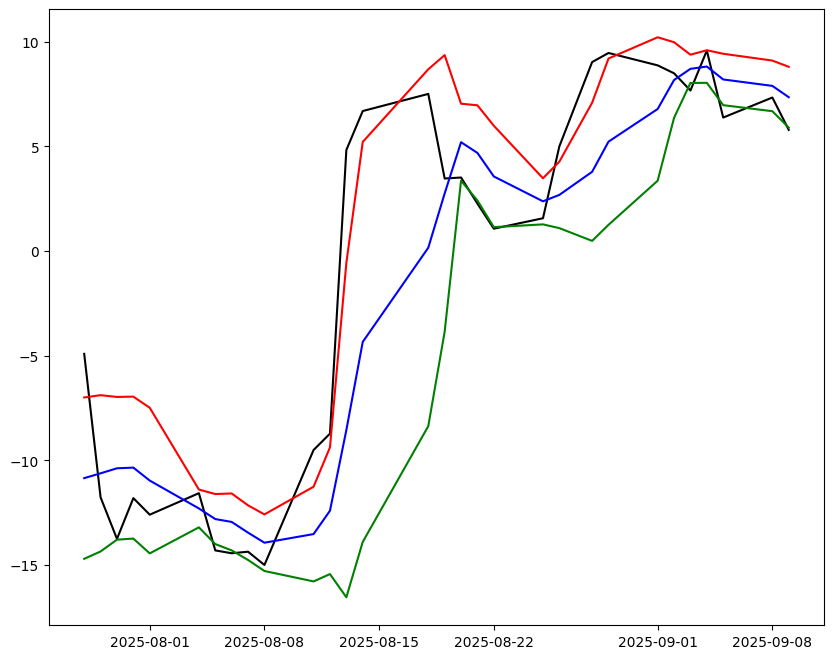

Starting backtest...
Exited position -1 on 2025-07-29 at 2025-07-29 13:31:00+05:30 | Intraday z -0.05
Exited position 1 on 2025-08-07 at 2025-08-07 09:15:00+05:30 | Intraday z 0.71
Exited position -1 on 2025-08-18 at 2025-08-18 15:23:00+05:30 | Intraday z 0.85
Exited position -1 on 2025-08-19 at 2025-08-19 15:23:00+05:30 | Intraday z 0.11
Exited position -1 on 2025-08-20 at 2025-08-20 09:15:00+05:30 | Intraday z -1.72
Exited position 1 on 2025-08-25 at 2025-08-25 10:19:00+05:30 | Intraday z 0.55
Exited position -1 on 2025-09-01 at 2025-09-01 15:23:00+05:30 | Intraday z 0.64
Exited position -1 on 2025-09-02 at 2025-09-02 12:11:00+05:30 | Intraday z -0.06
Exited position 1 on 2025-09-04 at 2025-09-04 11:07:00+05:30 | Intraday z 0.03
Exited position 1 on 2025-09-08 at 2025-09-08 15:23:00+05:30 | Intraday z -0.77
Exited position 1 on 2025-09-09 at 2025-09-09 15:23:00+05:30 | Intraday z -1.15


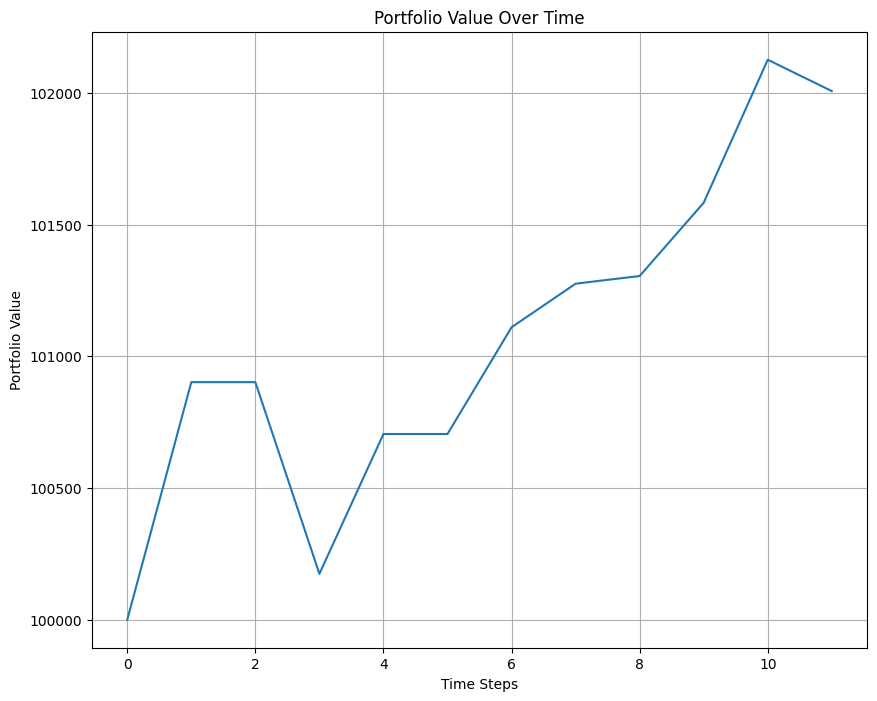

In [55]:
portfolio = complete_backtest( ALL_SECTORS , "2025-08-01" , "2025-09-09", "2025-07-22", "2025-09-09" , 100000)

In [ ]:
ticker1 = "GUJGASLTD"
ticker2 = "IGL"


## RESEARCH PURPOSE TO FIND PAIRS



In [19]:
data = best_pair_sectorwise(ALL_SECTOR_NAMES, ALL_SECTORS , "2025-08-04" , "2025-09-17")
df = pd.DataFrame(data)

In [20]:
df

,sector,ticker1,ticker2,hedge_ratio,p_value,correlation
0,FMCG_TICKER,BRITANNIA,UBL,3.070560,7.258359e-04,0.118597
1,ENERGY_TICKER,NHPC,PFC,0.202760,1.526195e-03,0.434087
2,OIL_GAS_TICKER,OIL,ONGC,1.728984,8.057971e-09,0.305519
3,PHARMA_TICKER,AUROPHARMA,DIVISLAB,0.173385,2.945625e-03,0.455001
4,CEMENT_TICKER,DALBHARAT,INDIACEM,6.152914,4.585964e-03,0.226952
5,METALS_TICKER,NMDC,SAIL,0.577340,4.114254e-05,0.698812
6,IT_TICKER,WIPRO,LTIM,0.047893,2.160785e-02,0.656958
7,AUTO_TICKER,ASHOKLEY,TATAMOTORS,0.188275,2.066413e-09,0.662311
8,BANK_TICKER,KOTAKBANK,ICICIBANK,1.390398,9.259952e-03,0.447247
9,FINANCIALS_TICKER,SHRIRAMFIN,BAJFINANCE,0.671367,1.690376e-05,0.524823


ANALYSIS FOR THE PAIR BRITANNIA AND UBL IN THE SECTOR FMCG_TICKER 


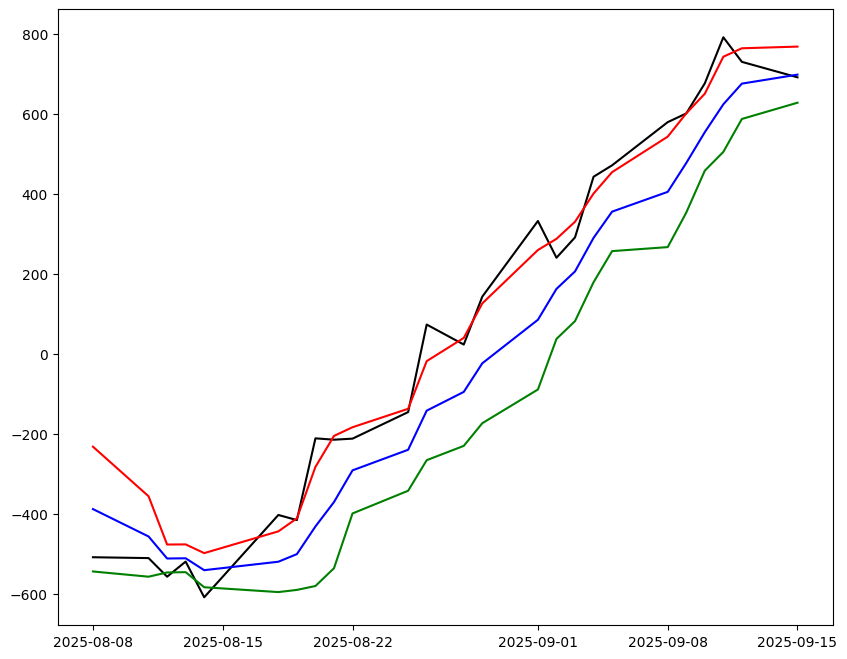

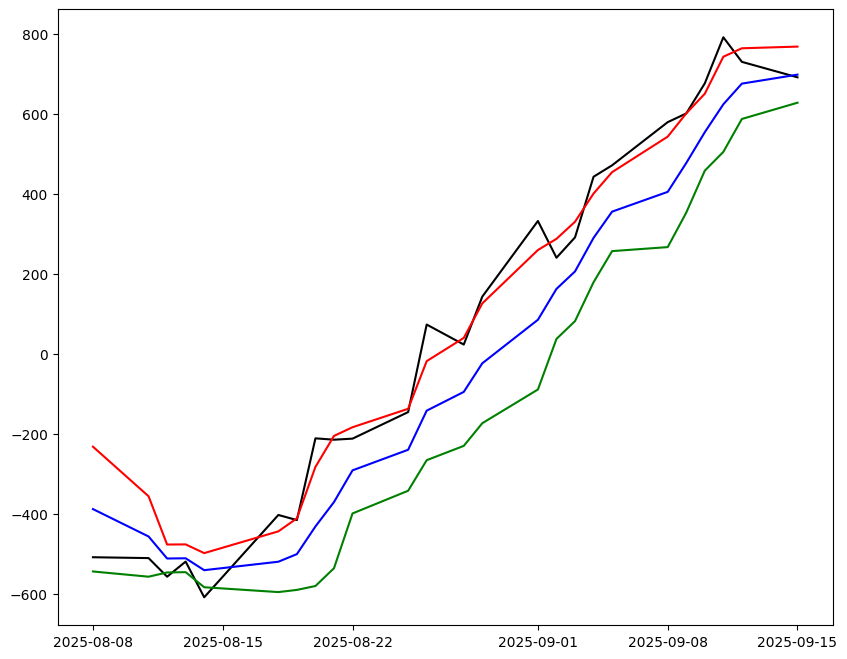

ANALYSIS FOR THE PAIR NHPC AND PFC IN THE SECTOR ENERGY_TICKER 


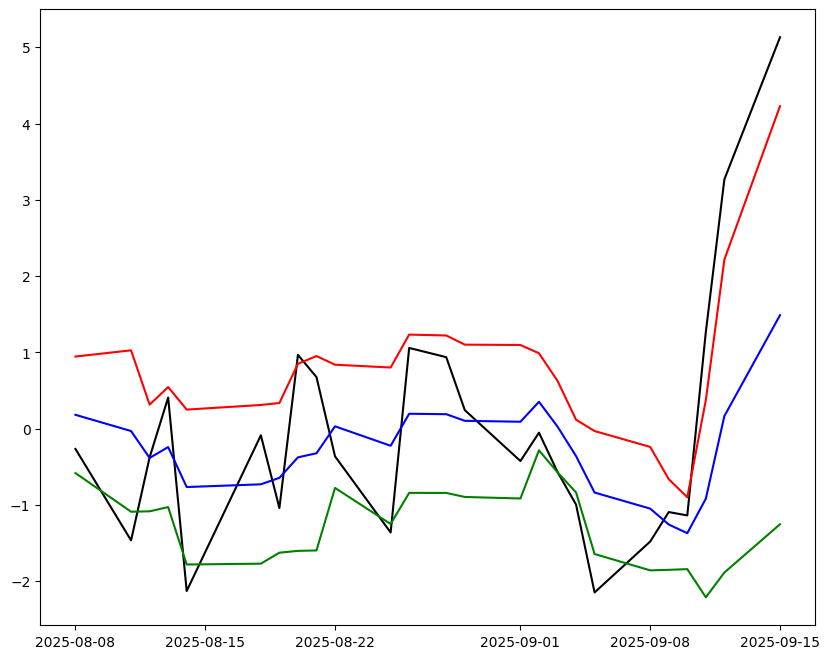

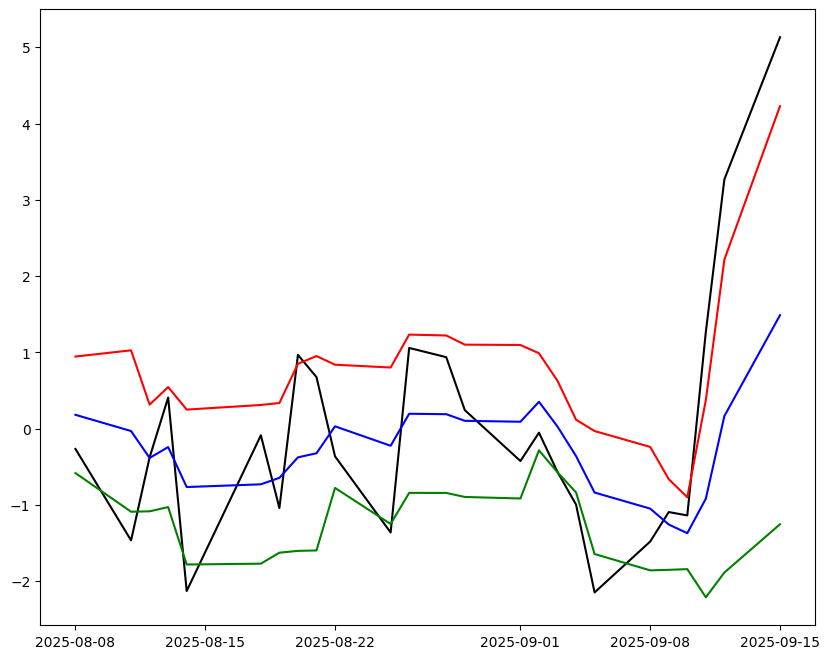

ANALYSIS FOR THE PAIR OIL AND ONGC IN THE SECTOR OIL_GAS_TICKER 


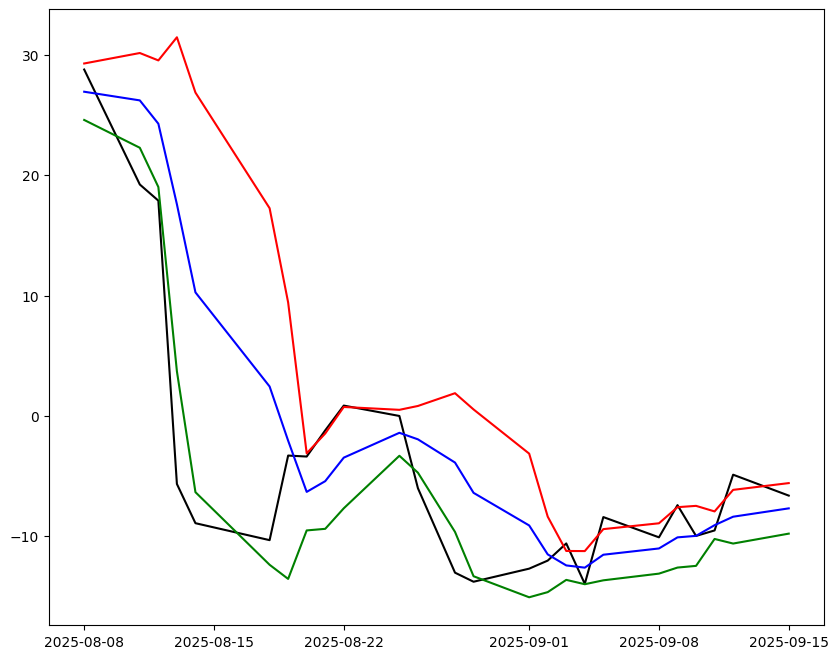

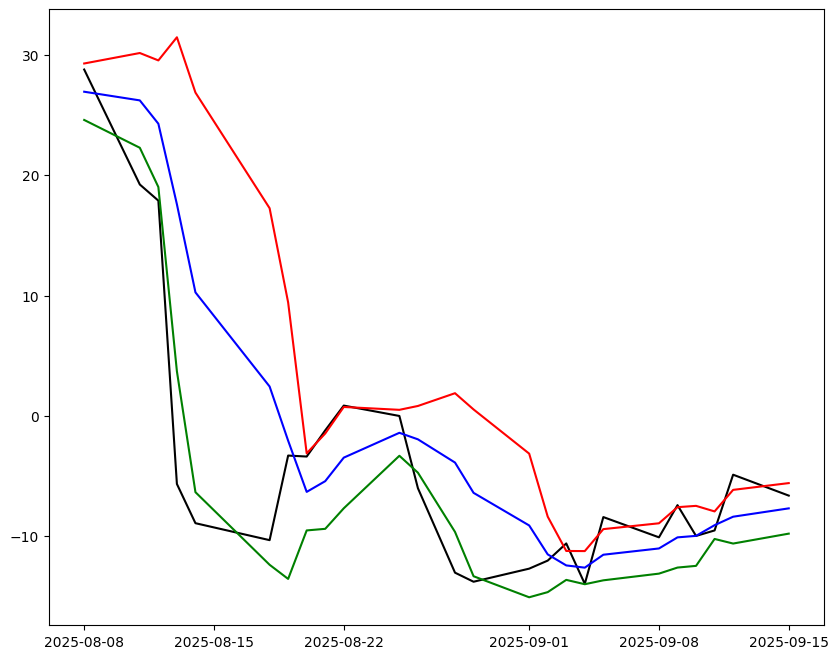

ANALYSIS FOR THE PAIR AUROPHARMA AND DIVISLAB IN THE SECTOR PHARMA_TICKER 


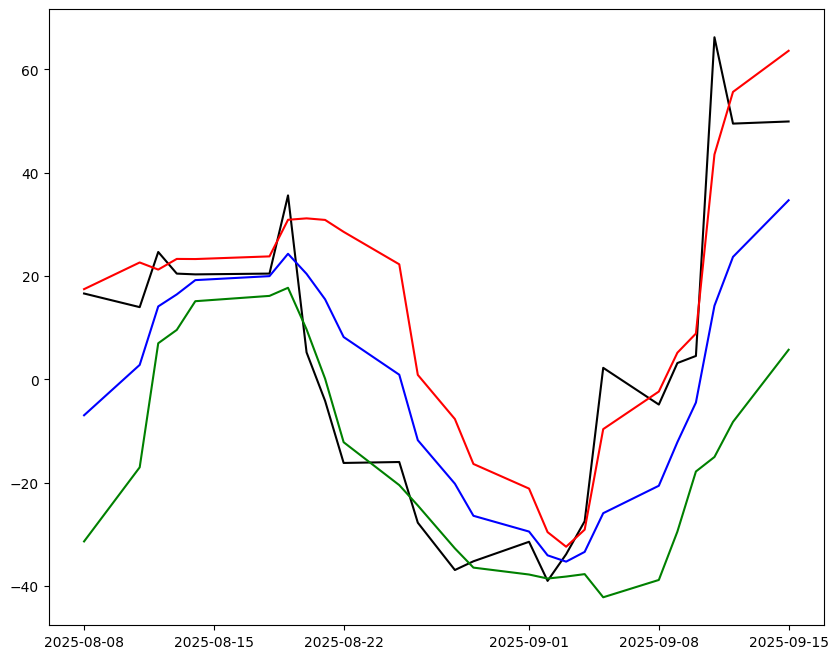

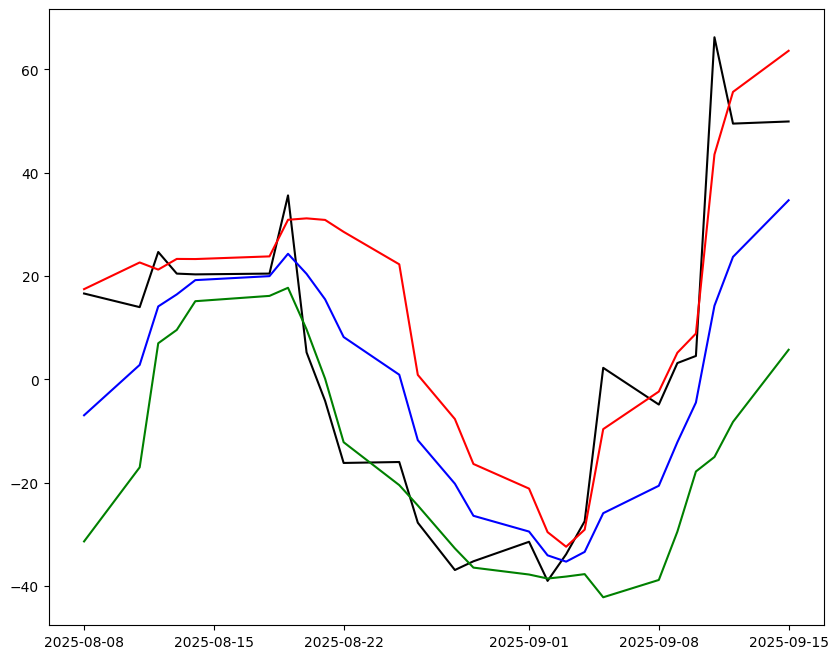

ANALYSIS FOR THE PAIR DALBHARAT AND INDIACEM IN THE SECTOR CEMENT_TICKER 


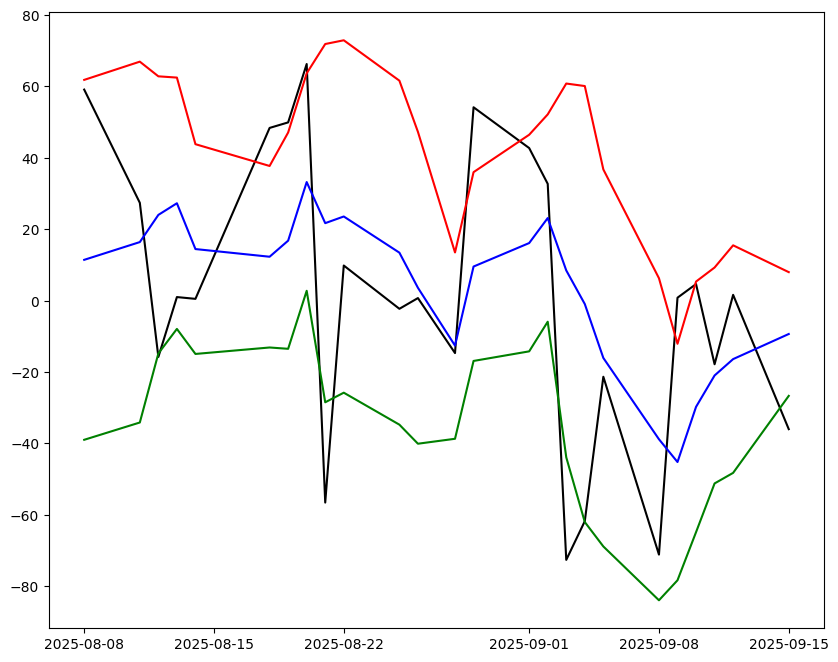

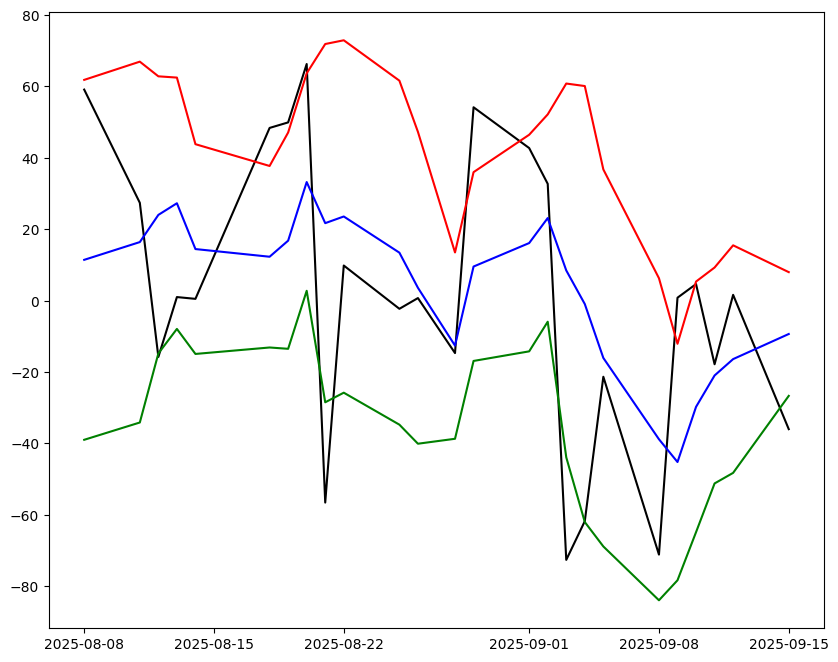

ANALYSIS FOR THE PAIR NMDC AND SAIL IN THE SECTOR METALS_TICKER 


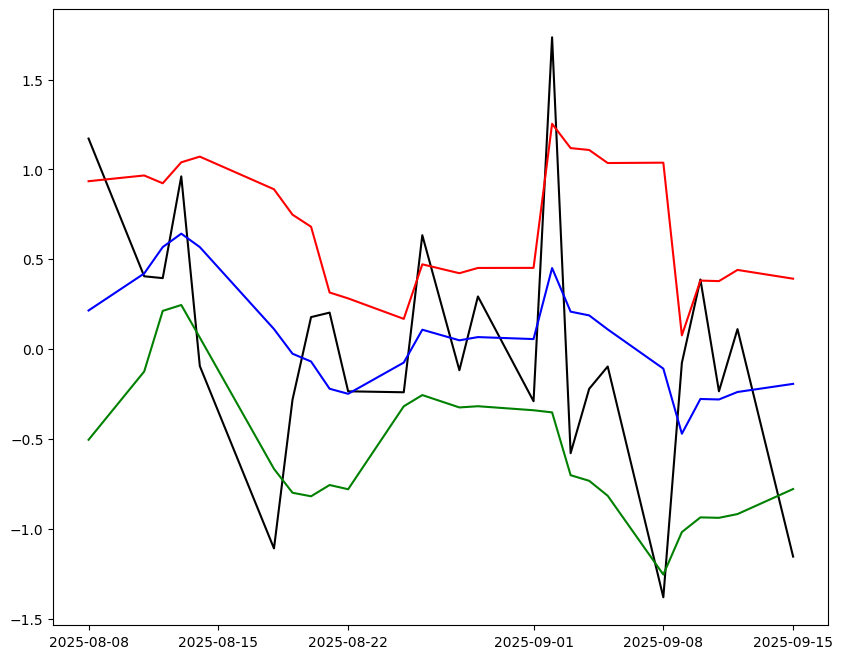

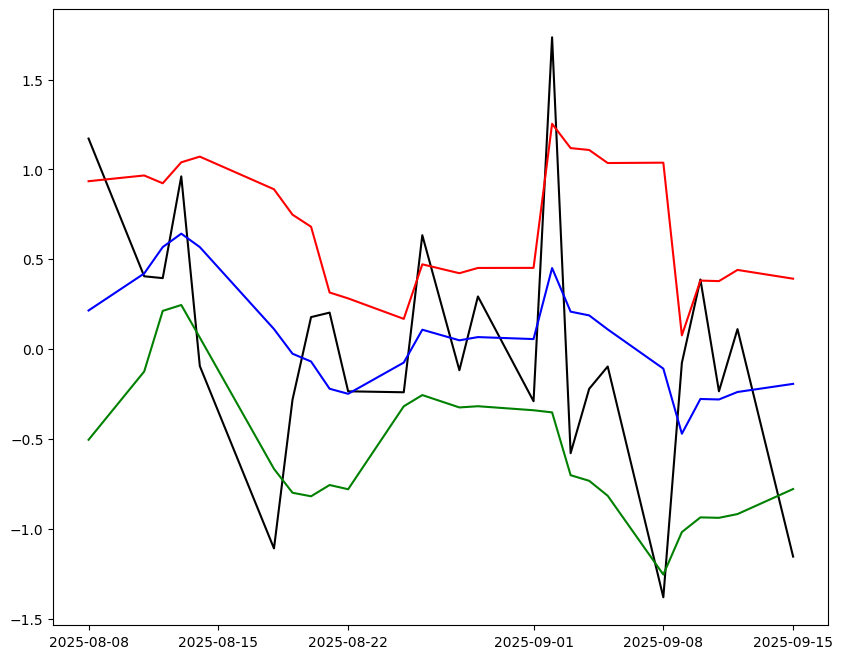

ANALYSIS FOR THE PAIR WIPRO AND LTIM IN THE SECTOR IT_TICKER 


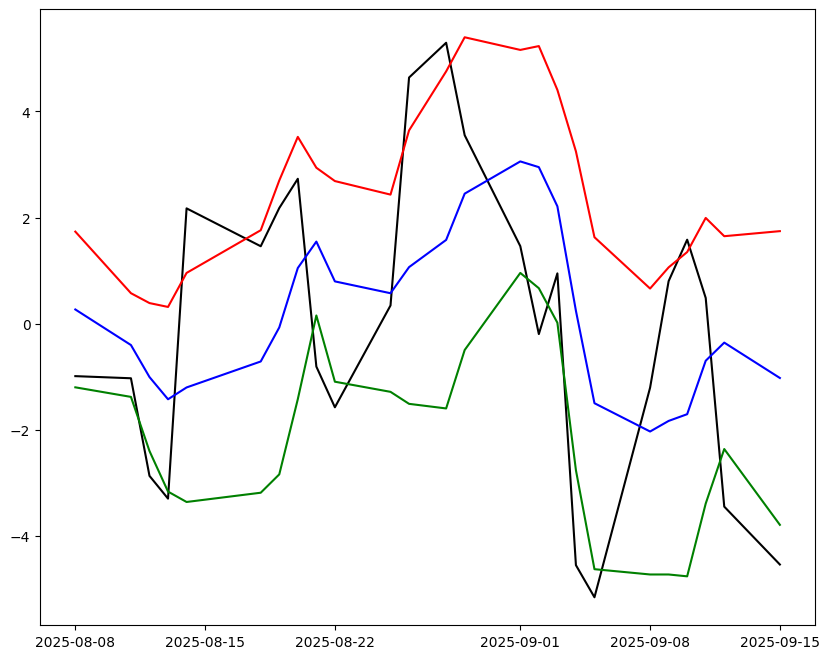

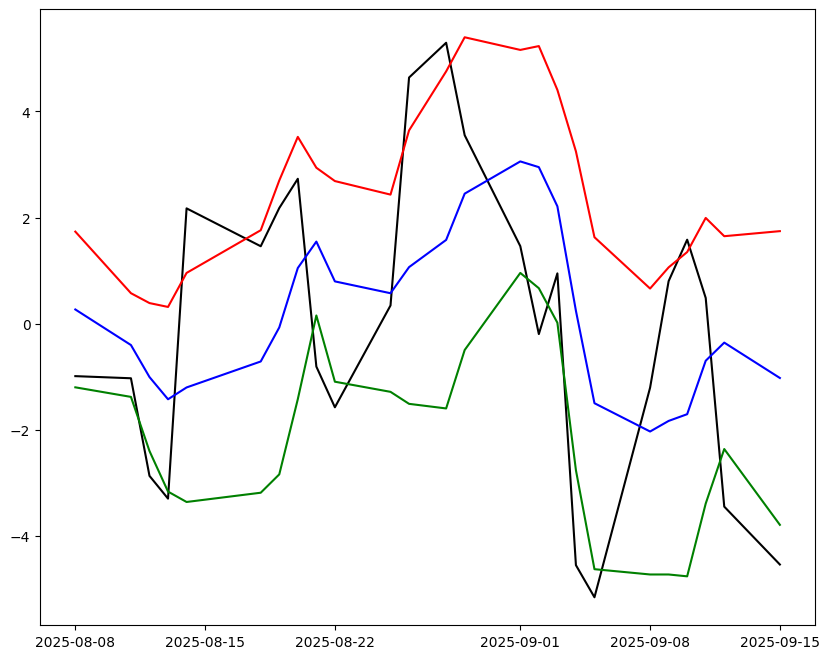

ANALYSIS FOR THE PAIR ASHOKLEY AND TATAMOTORS IN THE SECTOR AUTO_TICKER 


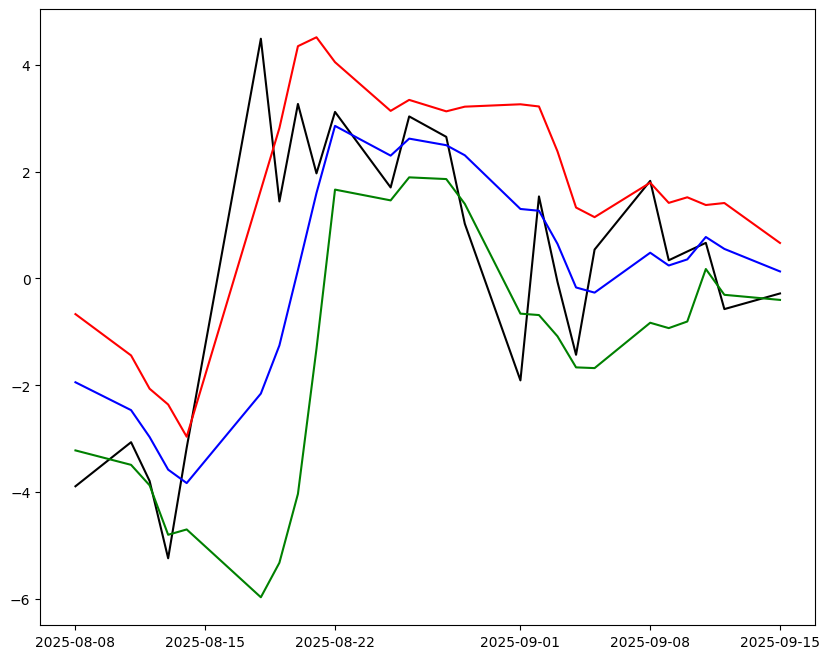

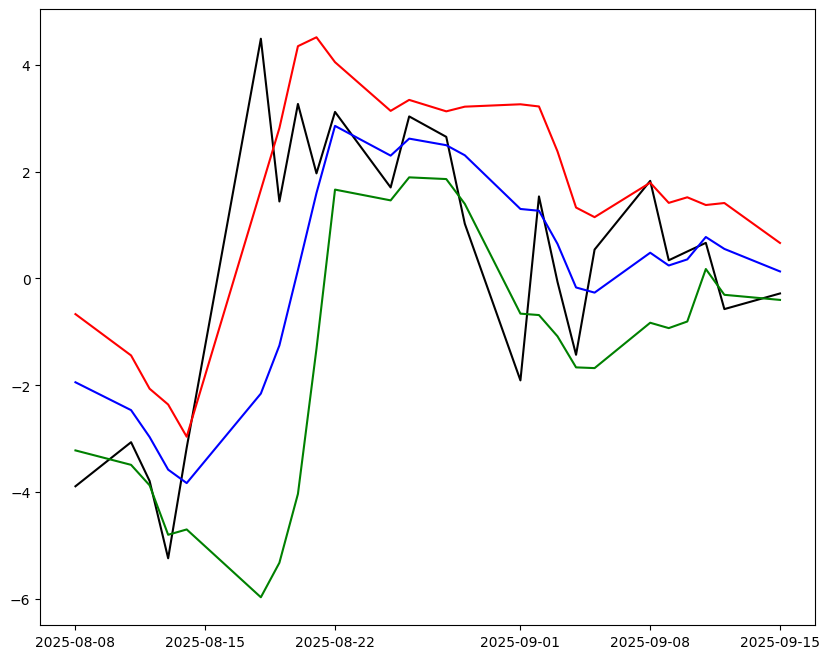

ANALYSIS FOR THE PAIR KOTAKBANK AND ICICIBANK IN THE SECTOR BANK_TICKER 


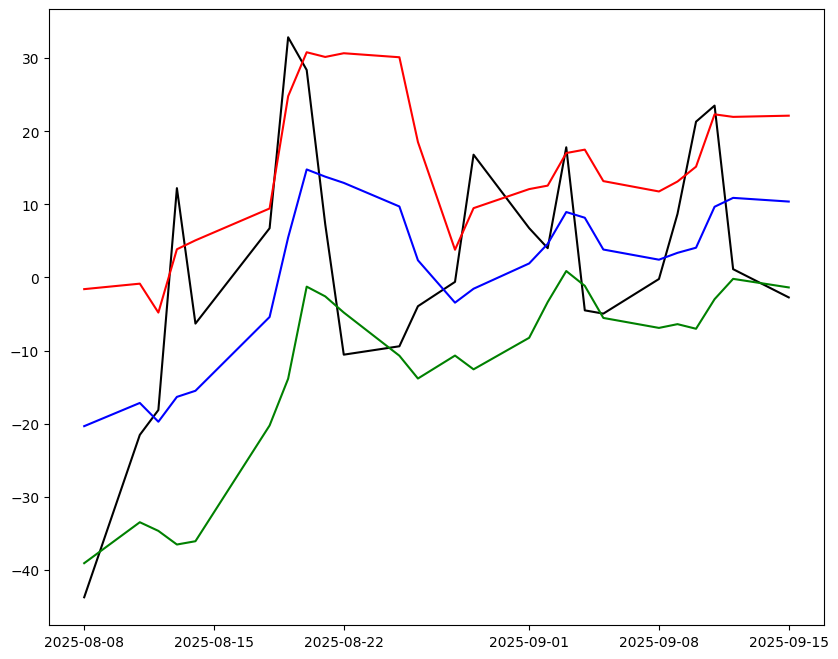

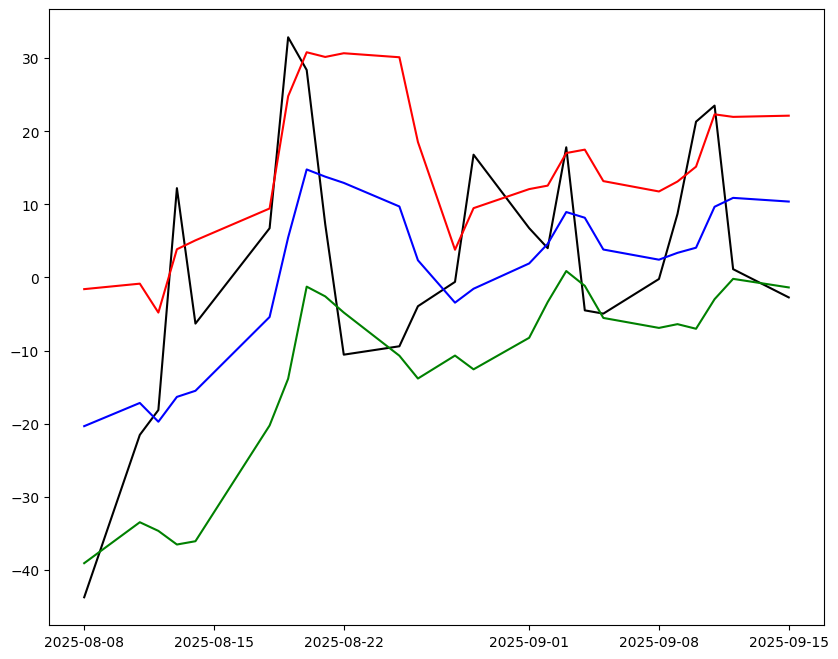

ANALYSIS FOR THE PAIR SHRIRAMFIN AND BAJFINANCE IN THE SECTOR FINANCIALS_TICKER 


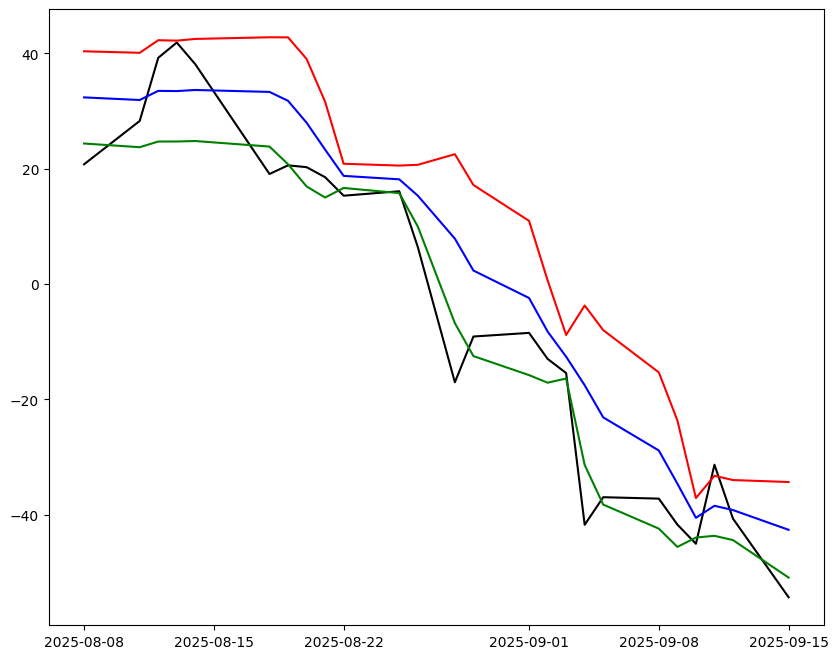

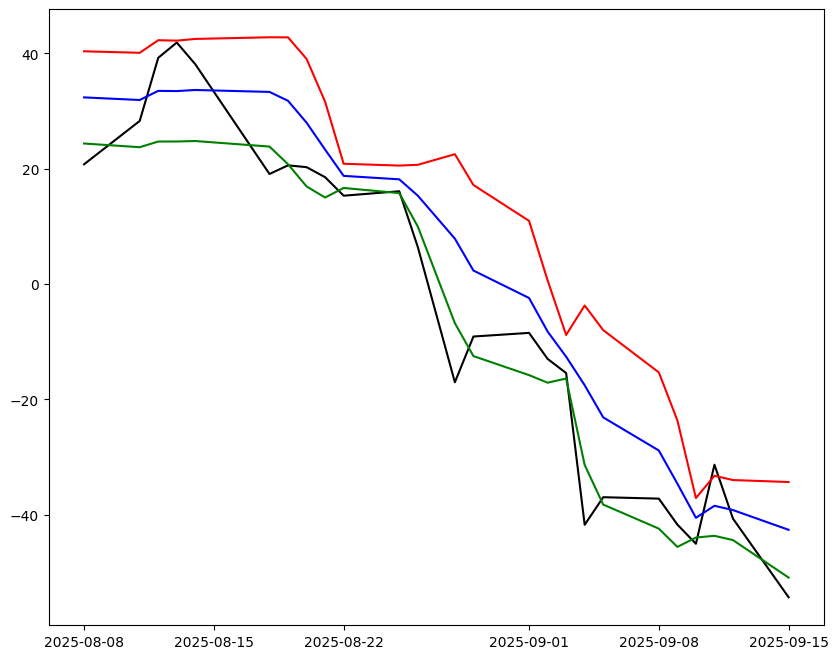

In [21]:
for idx,row in df.iterrows():
    print(F"ANALYSIS FOR THE PAIR {row["ticker1"]} AND {row["ticker2"]} IN THE SECTOR {row["sector"]} ")
    ticker1 = row["ticker1"]
    ticker2 = row["ticker2"]
    hedge_ratio = row["hedge_ratio"]
    window_list = [5, 7]
    for w in window_list:
        df_test = prepare_backtest_data(ticker1 , ticker2 , hedge_ratio , "2025-08-04" , "2025-09-17" , window_ = w)